# Retrieve a Eurobis dataset
Imagine you are interested in occurrence data, for instance this zooplankton dataset on [Eurobis](https://www.eurobis.org/imis?module=dataset&dasid=4687). You can also find this dataset via these portals:
- [IPT](https://www.vliz.be/nl/imis?module=dataset&dasid=4685&printversion=1&dropIMIStitle=1)
- [EMODnet](https://emodnet.ec.europa.eu/geonetwork/srv/eng/catalog.search#/metadata/6d617269-6e65-696e-666f-000000004687)
- [LifeWatch](https://rshiny.lifewatch.be/flowcam-data/)

This tutorial will illustrate how to get to this data via the DTO.
## 0. Setup environment
#### Requirements

In [1]:
packages = ["contextily",
            "pandas",
            "geopandas",
            "matplotlib",
            "pyarrow",
            "pystac_client"]

#### Install packages

In [2]:
for package in packages:
    %pip install {package}

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Load packages

In [3]:
import pyarrow.parquet as pq
import pyarrow.fs
import pyarrow.dataset as ds
import pyarrow.compute as pc
import pyarrow.fs
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point
import pystac_client

## 1. Find the occurrence dataset
On 2025-03-07 this is the current occurrence dataset: 
- s3.waw3-1.cloudferro.com/emodnet/biology/eurobis_occurrence_data/eurobis_occurrences_geoparquet_2024-10-01.parquet
<br><br>
The dataset is sometimes updated & URL changed, so it is best to search the STAC to make sure we have the latest version.
<br><br>
We use pystac_client to query the STAC, raed the docs [here](https://pystac-client.readthedocs.io/en/stable/index.html).
#### 1.1 Connect to STAC catalag

In [4]:
url = 'https://catalog.dive.edito.eu'
client = pystac_client.Client.open(url)
print(client)

<Client id=root>


Explore the different collections

In [5]:
collections = list(client.get_collections())
print(len(collections))

356


#### 1.2 Search collections with occurrence data

In [6]:
variable = "occurrence"

items = []
for collection in collections:
    if variable in collection.id:
        print(collection.id)
        for i, item in enumerate(collection.get_items()):
            items.append(item)
            
print(items)

emodnet-occurrence_data
[<Item id=426b87c6-409d-5dfd-9522-1be4e30b4b01>]


This results in one dataset that contains occurrence data.
#### 1.3 Find the data URL
Each item has assets, we want to find the parquet asset and extract that one.

In [7]:
for item in items:
    for key, value in item.assets.items():
        print(f"{key}: {value}")
        print("-"*25)
        if key == "parquet":
            occurrence_data = value.href

xml: <Asset href=https://emodnet.ec.europa.eu/geonetwork/srv/api/records/6d617269-6e65-696e-666f-000000001510/formatters/xml>
-------------------------
csw: <Asset href=https://emodnet.ec.europa.eu/geonetwork/emodnet/eng/csw?request=GetRecordById&service=CSW&version=2.0.2&elementSetName=full&id=6d617269-6e65-696e-666f-000000001510>
-------------------------
wms: <Asset href=https://geo.vliz.be/geoserver/wms?SERVICE=WMS&REQUEST=GetMap&LAYERS=Dataportal:eurobis_rasters-obisenv&VERSION=1.1.1&CRS=CRS:84&BBOX=-180,-90,180,90&WIDTH=800&HEIGHT=600&FORMAT=image/png>
-------------------------
parquet: <Asset href=https://s3.waw3-1.cloudferro.com/emodnet/biology/eurobis_occurrence_data/eurobis_occurrences_geoparquet_2024-10-01.parquet>
-------------------------
parquet-datalab-data-explorer: <Asset href=https://datalab.dive.edito.eu/data-explorer?source=https://s3.waw3-1.cloudferro.com/emodnet/biology/eurobis_occurrence_data/eurobis_occurrences_geoparquet_2024-10-01.parquet>
--------------------

In [8]:
print(occurrence_data)

https://s3.waw3-1.cloudferro.com/emodnet/biology/eurobis_occurrence_data/eurobis_occurrences_geoparquet_2024-10-01.parquet


## 2. Open the occurrences dataset
#### connect to the S3 object storage 
To connect to the dataset, you need following information:

- Host: base url 
- Bucket: first part of the path after host 
- Key: all other path specifications

This information is all in the URI. It can be extracted manualy or automated.
#### Manual resource specification

In [9]:
host = "s3.waw3-1.cloudferro.com"
bucket_name = "emodnet"
key = "biology/eurobis_occurrence_data/eurobis_occurrences_geoparquet_2024-10-01.parquet"

#### Automated resource specification

In [10]:
from urllib.parse import urlparse
parsed_url = urlparse(occurrence_data)
host = parsed_url.hostname
bucket_name = parsed_url.path.split('/')[1]
key = '/'.join(parsed_url.path.split('/')[2:])

In [11]:
print("host =", host)
print("bucket_name =", bucket_name)
print("key =", key)

host = s3.waw3-1.cloudferro.com
bucket_name = emodnet
key = biology/eurobis_occurrence_data/eurobis_occurrences_geoparquet_2024-10-01.parquet


In [12]:
s3 = pyarrow.fs.S3FileSystem(endpoint_override=host, anonymous=True)
s3_path = f"{bucket_name}/{key}"

#### Open file and inspect the schema
Open the dataset. Notice this is not equal to loading the data. The entire dataset contains way to many records to load at once, we will filter en load in a later step.

In [19]:
dataset = ds.dataset(s3_path, filesystem=s3, format="parquet")
print(dataset.schema)

occurrenceid: int32
datasetid: int32
observationdate: timestamp[us, tz=UTC]
longitude: double
latitude: double
scientificname: string
aphiaid: int32
scientificname_accepted: string
aphiaidaccepted: int32
taxonrank: int32
geometry: binary
  -- field metadata --
  ARROW:extension:metadata: '      crs�   GEOGCS["WGS 84",DATUM["WGS_19' + 198
  ARROW:extension:name: 'geoarrow.wkb'
-- schema metadata --
geo: '{"version":"0.3.0","primary_column":"geometry","columns":{"geometry' + 340


## 2. Filter the data
We will filter for copepods (apiaID 1080 near the Flemish coast (latitude 51-51.5; longitude 2.5-3.3).

In [13]:
filtered_table = dataset.to_table(
    filter=(
        (pc.field("aphiaid") == 1080) &
        (pc.field("latitude") >= 51) &
        (pc.field("latitude") <= 51.5) &
        (pc.field("longitude") >= 2.5) &
        (pc.field("longitude") <= 3.3)
    )
)

#### Convert to Pandas DataFrame

In [14]:
df = filtered_table.to_pandas()

See how many records in this dataframe

In [15]:
print(f"{len(df)=}")

len(df)=1477


Print some records to see the data.

In [16]:
for line in df.head(10).itertuples():
    print(line)

Pandas(Index=0, occurrenceid=38279854, datasetid=67, observationdate=Timestamp('1986-04-02 00:00:00+0000', tz='UTC'), longitude=2.5, latitude=51.25, scientificname='Copepoda', aphiaid=1080, scientificname_accepted='Copepoda', aphiaidaccepted=1080, taxonrank=60, geometry=b'\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04@\x00\x00\x00\x00\x00\xa0I@')
Pandas(Index=1, occurrenceid=119851535, datasetid=4688, observationdate=Timestamp('2020-06-23 00:00:00+0000', tz='UTC'), longitude=2.50042117, latitude=51.3342685, scientificname='Copepoda', aphiaid=1080, scientificname_accepted='Copepoda', aphiaidaccepted=1080, taxonrank=60, geometry=b'\x01\x01\x00\x00\x00*\x02{\xd0\xdc\x00\x04@\x9f\xcaiO\xc9\xaaI@')
Pandas(Index=2, occurrenceid=119862435, datasetid=4688, observationdate=Timestamp('2021-09-28 00:00:00+0000', tz='UTC'), longitude=2.50075983, latitude=51.33369755, scientificname='Copepoda', aphiaid=1080, scientificname_accepted='Copepoda', aphiaidaccepted=1080, taxonrank=60, geometry=b'\x01\x

You may notice not all fields are available. In fact this dataset only contains occurences and no count or densities. This is something that will be fixed in e next update.

## 3.Plotting the data
Lets visualize the data for better understanding.

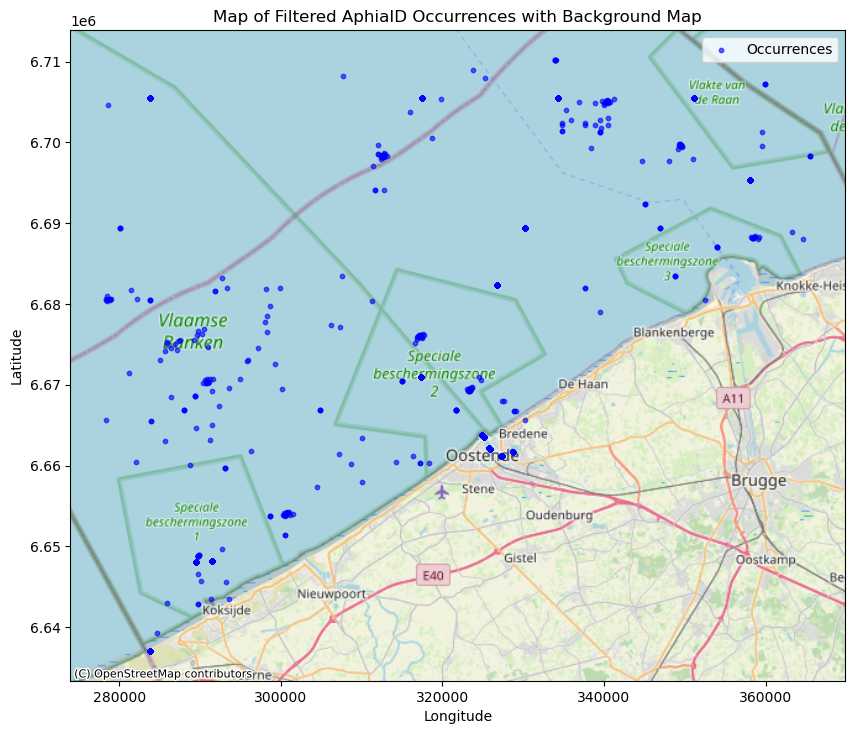

In [17]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"  # WGS84 coordinate system
)
fig, ax = plt.subplots(figsize=(10, 10))
gdf = gdf.to_crs(epsg=3857)  # Reproject to Web Mercator for compatibility with contextily
gdf.plot(ax=ax, color="blue", markersize=10, alpha=0.6, label="Occurrences")
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=10)
ax.set_title("Map of Filtered AphiaID Occurrences with Background Map")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.legend()
plt.show()

## 4. Conclusion
This notebook demonstrated how to reach the Eurobis data via EDITO data lake. All occurence datasets are merged in a single parquet file in the data lake. So its not a good practice to search for a specific dataset. The way to go is to filter on AphiaID and lat/lon and retrieve all available occurences. 